In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from imutils import imshow

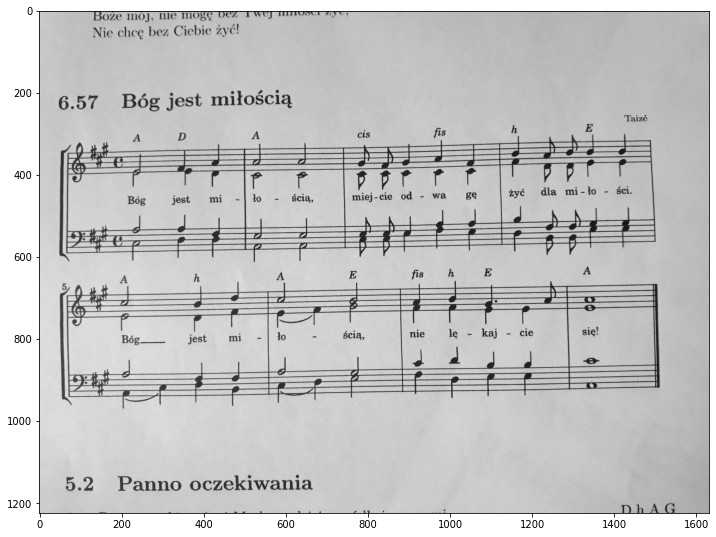

In [2]:
# load a photo of printed sheet music taken with a mobile phone

im = cv2.imread('sample.jpg', 0)
height, width = im.shape
imshow(im)

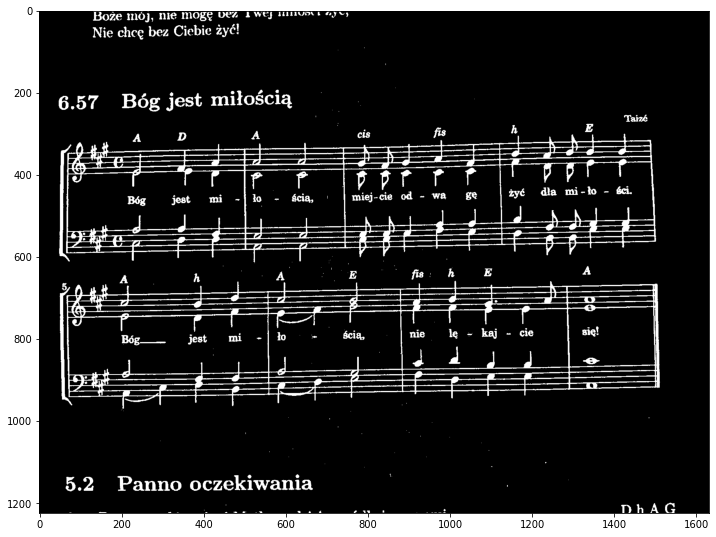

In [3]:
# binarize the image

im_bin = 255 - cv2.adaptiveThreshold(im, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,127,10)
imshow(im_bin)

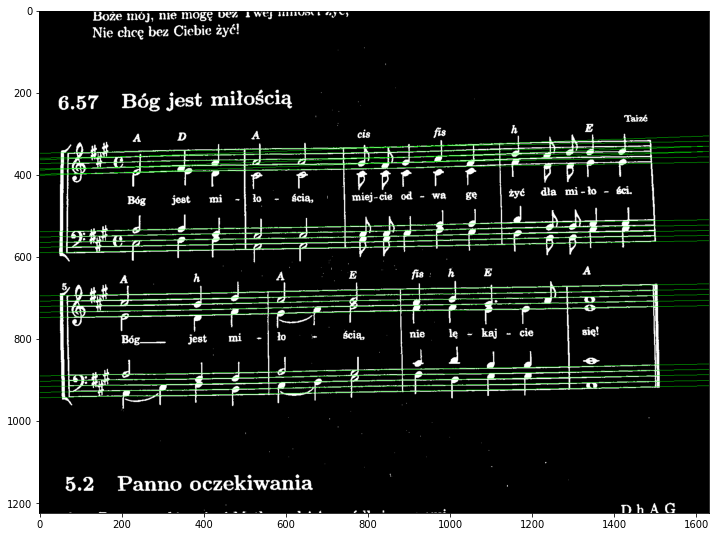

In [4]:
# detect staff lines using the Hough transform

im2 = cv2.cvtColor(im_bin, cv2.COLOR_GRAY2BGR)

lines = cv2.HoughLines(im_bin, 1, np.pi/180, 750)

for line in lines:
    rho, theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + width*(-b))
    y1 = int(y0 + width*(a))
    x2 = int(x0 - width*(-b))
    y2 = int(y0 - width*(a))

    cv2.line(im2, (x1,y1), (x2,y2), (0,255,0), 1)
imshow(im2)

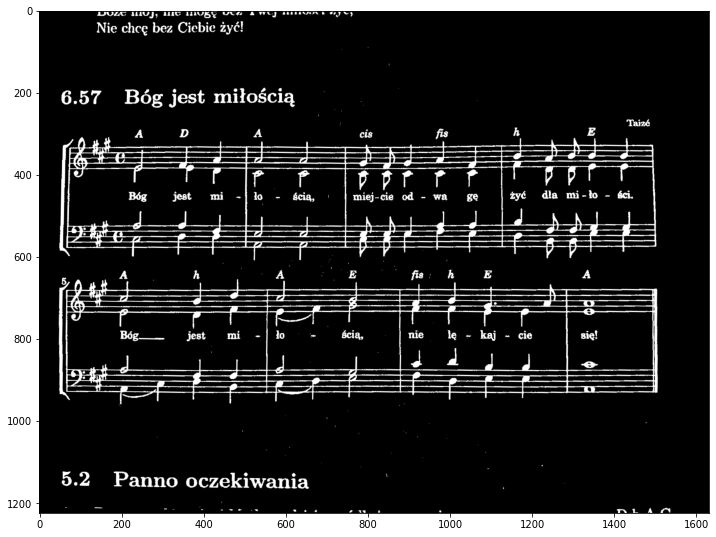

In [5]:
# use detected lines to determine a rotation angle and straighten the image

angles =  np.degrees(lines[:, 0, 1] - np.pi/2)
angle = np.median(angles)

def rotate_image(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
  return result

im_rot = rotate_image(im_bin, angle)
imshow(im_rot)



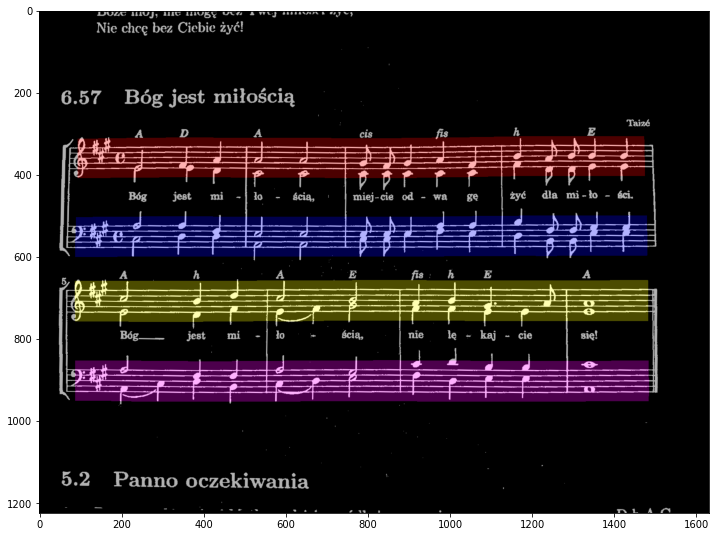

In [6]:
# find bounding boxes of individual staffs

from skimage.measure import label, regionprops
from skimage.color import label2rgb

im2 = cv2.cvtColor(im_rot, cv2.COLOR_GRAY2BGR)

morph_size = 45

im_staves = im_rot
kernel1 = cv2.getStructuringElement(cv2.MORPH_RECT, (1, morph_size))
im_staves = cv2.dilate(im_staves, kernel1, iterations=1)
kernel2 = cv2.getStructuringElement(cv2.MORPH_RECT, (morph_size, 1))
im_staves = cv2.erode(im_staves, kernel2, iterations=1)

kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (morph_size, morph_size))
im_staves = cv2.morphologyEx(im_staves, cv2.MORPH_OPEN, kernel3) > 127

staves = label(im_staves)
label_overlay = label2rgb(staves, image=im_rot, bg_label=0)

imshow(label_overlay)

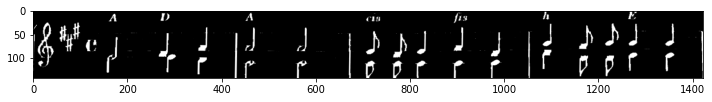

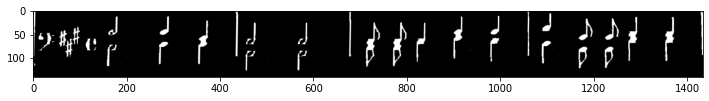

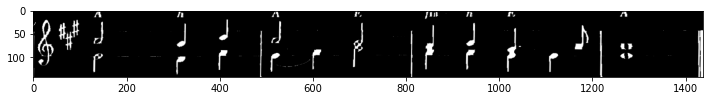

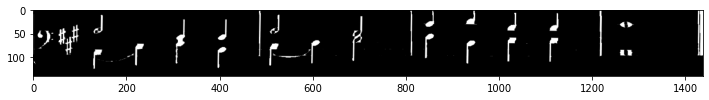

In [7]:
# extract individual staves, remove lines

margin = 20

for region in regionprops(staves):
    y0, x0, y1, x1 = region.bbox
    staff = im_rot[y0-margin:y1+margin, x0-margin:x1+margin]

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,5))
    staff_nolines = cv2.erode(staff, kernel, iterations=1)
    imshow(staff_nolines)